In [1]:
# Carrega as variáveis de embiente usadas pelo notebook. Estas variáveis devem ser criadas no arquivo .env, localizada no mesmo diretório do notebook
# As seguintes variáveis devem ser criadas:
# - export STR_CON=<string de conexão com o banco de dados relacional>
# - export RAW_DATA_PATH=<caminho onde os arquivos contendo o histórico de preço de cada ativo será armazenado>
# - export DATASET_PATH=<caminho onde os arquivos contendo o histórico de preço e os indicadores técnicos serão armazenados>
# - export MODELS_PATH=<caminnho onde os modelos treinados serão armazenados>
# - export TRAIN_DATASET=<caminho onde os datasets estandarizados e formatados para o treinamento serão armazenados>
%load_ext dotenv
%dotenv

# Garante que os scripts Python sejam recarregados em cada execução do notebook.
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from data_preparation import PreProcess

preprocess = PreProcess()
df_train = preprocess.read_dataset_from_parquet("data/train_dataset/Sinais-com-historico/train_data.parquet")
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/Sinais-com-historico/test_data.parquet")

Y_Train = df_train.pop("label")
Y_Test = df_test.pop("label")

X_Train = np.array([val[0] for val in df_train.values])
X_Test = np.array([val[0] for val in df_test.values])

In [4]:
X_Train.shape

(56503, 45, 27)

Model: "cnn_indicators"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 45, 27, 1)]       0         
                                                                 
 conv2d_layer1 (Conv2D)      (None, 45, 27, 3)         33        
                                                                 
 batch_normalization_16 (Bat  (None, 45, 27, 3)        12        
 chNormalization)                                                
                                                                 
 flatten_12 (Flatten)        (None, 3645)              0         
                                                                 
 dense_256 (Dense)           (None, 256)               933376    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                    

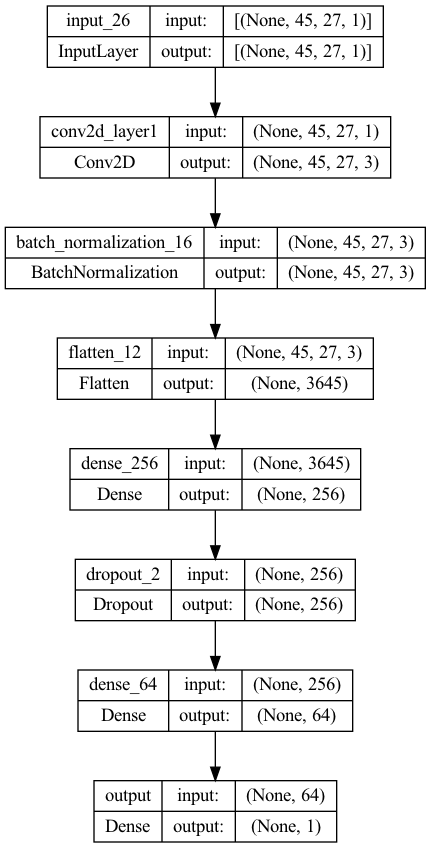

In [45]:
import tensorflow as tf
from keras import Input, Model
from keras.layers import Conv2D, Dense, LSTM, Dropout, Conv2D, BatchNormalization, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.metrics import AUC


X_Train_reshaped = np.reshape(X_Train, (X_Train.shape[0], X_Train.shape[1], X_Train.shape[2], 1))
X_Test_reshaped = np.reshape(X_Test, (X_Test.shape[0], X_Test.shape[1], X_Test.shape[2], 1))

tf.get_logger().setLevel('INFO')
tf.debugging.set_log_device_placement(False)
metric = "accuracy"

early_stopping = EarlyStopping(monitor=f'val_{metric}', 
                               patience=10, 
                               min_delta=0.001, 
                               mode='max')

cp_model_checkpoint = ModelCheckpoint("data/tf_models/benchmark/conv2d_lstm-{epoch:02d}-{val_accuracy:.4f}.h5",
                                      monitor=f'val_{metric}',
                                      save_best_only=True,
                                      verbose=1,
                                      mode="max")

input_layer = Input(shape=X_Train_reshaped.shape[1:])
hidden_layers = Conv2D(name="conv2d_layer1",
                   filters=3,
                   kernel_size=(10, 1),
                   activation="relu",
                   padding="same",
                   input_shape=(X_Train.shape[1], X_Train.shape[2], 1))(input_layer)
# hidden_layers = Conv2D(name="conv2d_layer2",
#                    filters=32,
#                    kernel_size=(1, 10),
#                    activation="relu",
#                    padding="same",
#                    input_shape=(X_Train.shape[1], X_Train.shape[2], 1))(hidden_layers)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Flatten()(hidden_layers)
# hidden_layers = Dense(1024, activation="relu", name="dense_1024")(hidden_layers)
# hidden_layers = Dropout(0.3, name="dropout_1")(hidden_layers)
hidden_layers = Dense(256, activation="relu", name="dense_256", kernel_regularizer='l2')(hidden_layers)
hidden_layers = Dropout(0.3, name="dropout_2")(hidden_layers)
hidden_layers = Dense(64, activation="relu", name="dense_64", kernel_regularizer='l2')(hidden_layers)
# hidden_layers = Dropout(0.3, name="dropout_3")(hidden_layers)
# hidden_layers = Dense(32, activation="relu", name="dense_32", kernel_regularizer='l2')(hidden_layers)
# hidden_layers = Dense(16, activation="relu", name="dense_16")(hidden_layers)
output_layer = Dense(1, activation="sigmoid", name="output")(hidden_layers)

cnn_model = Model(inputs=input_layer, outputs=output_layer, name="cnn_indicators")

cnn_model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  metrics=[metric])

cnn_model.build(input_shape=X_Train.shape[1:])

print(cnn_model.summary())
plot_model(cnn_model, 'cnn_model.png', show_shapes=True)


In [46]:
batch_size = 32
epochs = 100

history = cnn_model.fit(X_Train[:1000], 
                        Y_Train[:1000], 
                        batch_size=batch_size, 
                        epochs=epochs,
                        validation_data=(X_Test, Y_Test), 
                        callbacks=[early_stopping, cp_model_checkpoint])# 
                    
index = history.history[f'val_{metric}'].index(max(history.history[f'val_{metric}']))
max(history.history[f'val_{metric}'])#, history.history['val_recall'][index]

Epoch 1/100


2022-12-20 21:25:29.526986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 5.1995 - accuracy: 0.5670

2022-12-20 21:25:34.893730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.61286, saving model to data/tf_models/benchmark/conv2d_lstm-01-0.6129.h5
32/32 [==============================] - 15s 432ms/step - loss: 5.1995 - accuracy: 0.5670 - val_loss: 3.5813 - val_accuracy: 0.6129
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 2.9316 - accuracy: 0.5870
Epoch 2: val_accuracy did not improve from 0.61286
32/32 [==============================] - 10s 314ms/step - loss: 2.9316 - accuracy: 0.5870 - val_loss: 2.3977 - val_accuracy: 0.4767
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 2.0696 - accuracy: 0.6230
Epoch 3: val_accuracy did not improve from 0.61286
32/32 [==============================] - 10s 312ms/step - loss: 2.0696 - accuracy: 0.6230 - val_loss: 1.7935 - val_accuracy: 0.6102
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 1.5913 - accuracy: 0.6290
Epoch 4: val_accuracy improved from 0.61286 to 0.61326, saving model to data/tf_models/benchmark/

0.6132553219795227

In [38]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import load_model

model = load_model("data/tf_models/benchmark/conv2d_lstm-01-0.6129.h5")
Y_test_predict = (model.predict(X_Test).flatten() > 0.5).astype(int)
print(f"Accuracy: {accuracy_score(Y_Test.values, Y_test_predict):.4f}")
print("Matriz de confusao:\n", confusion_matrix(Y_Test.values, Y_test_predict))
print(f"Precision: {precision_score(Y_Test.values, Y_test_predict):.4f}")
print(f"Recall: {recall_score(Y_Test.values, Y_test_predict):.4f}")
print(f"F1 Score: {f1_score(Y_Test.values, Y_test_predict):.4f}")

2022-12-20 19:35:32.475944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


315/315 [==============================] - 5s 14ms/step
Accuracy: 0.6129
Matriz de confusao:
 [[6177    0]
 [3902    0]]
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/Users/ricardomonteiro/pythonProjects/projects/proj_final_bimaster/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
